# E-News Express project
An online news portal aims to expand its business by acquiring new subscribers. Every visitor to the website takes certain actions based on their interest. The company plans to analyze these interests and wants to determine whether a new feature will be effective or not. Companies often analyze users' responses to two variants of a product to decide which of the two variants is more effective.
We would perform A/B testing to understand effectiveness of new planding page.

## Important Pointers
* Random Population of 100 Samples
* Two groups namely Control and Treatment with equal samples
* Consider a significance level of 0.05 for all tests.

## Objective
To understand the data and perform statistical analysis to answer following questions
* Perform EDA and provide insights.
* Do the users spend more time on the new landing page than the old landing page?
* Is the conversion rate (the proportion of users who visit the landing page and get converted) for the new page greater than the conversion rate for the old page?
* Does the converted status depend on the preferred language? 
* Is the mean time spent on the new page same for the different language users?


In [86]:
#import required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
sns.set(color_codes=True) # adds a nice background to the graphs
%matplotlib inline 
# tells python to actually display the graphs
import warnings # Libray to suppress warnings and any deprecated package info for Prod scenario **not to be used in development environment
warnings.filterwarnings('ignore')

In [87]:
# read data in to Pandas Dataframe for analysis
udata = pd.read_csv("abtest.csv")

#Take backup incase
udata_backup = udata.copy()

In [88]:
# Check structure of data
udata.shape

(100, 6)

In [90]:
# Check data structure
udata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   user_id                 100 non-null    int64  
 1   group                   100 non-null    object 
 2   landing_page            100 non-null    object 
 3   time_spent_on_the_page  100 non-null    float64
 4   converted               100 non-null    object 
 5   language_preferred      100 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 4.8+ KB


#### Inital Inference
* Data has 6 columns and 100 rows
* Time_spent_on_page and user_id are numerical values
* Group, Landing_page, COnverted, language_preferred are categorical values

In [92]:
# Convert Categorical values
udata['landing_page'] = udata.landing_page.astype('category')
udata['converted'] = udata.converted.astype('category')
udata['language_preferred'] = udata.language_preferred.astype('category')

In [91]:
# Do statistical analysis
udata.describe()

,user_id,time_spent_on_the_page
count,100.000000,100.000000
mean,546517.000000,5.377800
std,52.295779,2.378166
min,546443.000000,0.190000
25%,546467.750000,3.880000
50%,546492.500000,5.415000
75%,546567.250000,7.022500
max,546592.000000,10.710000


* Mean time spent is 5. Looks like normally distributed data
* max value indicates there may be outliers.
* User_id can be ignored for analysis

In [96]:
udata.head() # View top 5 rows

,user_id,group,landing_page,time_spent_on_the_page,converted,language_preferred
0,546592,control,old,3.48,no,Spanish
1,546468,treatment,new,7.13,yes,English
2,546462,treatment,new,4.40,no,Spanish
3,546567,control,old,3.02,no,French
4,546459,treatment,new,4.75,yes,Spanish


In [95]:
udata.tail() #view bottom five rows

,user_id,group,landing_page,time_spent_on_the_page,converted,language_preferred
95,546446,treatment,new,5.15,no,Spanish
96,546544,control,old,6.52,yes,English
97,546472,treatment,new,7.07,yes,Spanish
98,546481,treatment,new,6.20,yes,Spanish
99,546483,treatment,new,5.86,yes,English


In [97]:
#Check for null values
udata.isnull()

,user_id,group,landing_page,time_spent_on_the_page,converted,language_preferred
0,False,False,False,False,False,False
1,False,False,False,False,False,False
2,False,False,False,False,False,False
3,False,False,False,False,False,False
4,False,False,False,False,False,False
...,...,...,...,...,...,...
95,False,False,False,False,False,False
96,False,False,False,False,False,False
97,False,False,False,False,False,False
98,False,False,False,False,False,False


<AxesSubplot:>

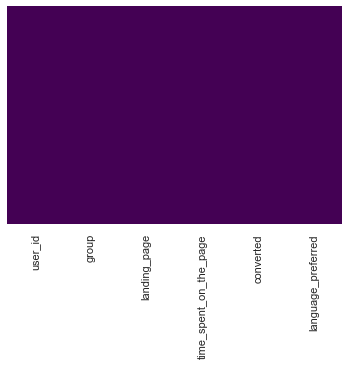

In [16]:
# Above method doesn't show for all data, this chart might help
sns.heatmap(udata.isnull(),yticklabels=False,cbar=False,cmap='viridis') 

In [99]:
udata.describe(exclude='number')# TO check for non-numerical attributes

,group,landing_page,converted,language_preferred
count,100,100,100,100
unique,2,2,2,3
top,control,new,yes,French
freq,50,50,54,34


* As mentioned equal number of users for old and new landing page
* French language preference users are most used in sample
* COnversion ratio is just above half of population, may indicate effectiveness of new page

In [19]:
udata.nunique(axis=0) # check for unique values

user_id                   100
group                       2
landing_page                2
time_spent_on_the_page     94
converted                   2
language_preferred          3
dtype: int64

## EDA

In [101]:
# While doing uni-variate analysis of numerical variables we want to study their central tendency 
# and dispersion.
# Let us write a function that will help us create boxplot and histogram for any input numerical 
# variable.
# This function takes the numerical column as the input and returns the boxplots 
# and histograms for the variable.
# Let us see if this help us write faster and cleaner code.
# function to plot a boxplot and a histogram along the same scale.


def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to show the density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

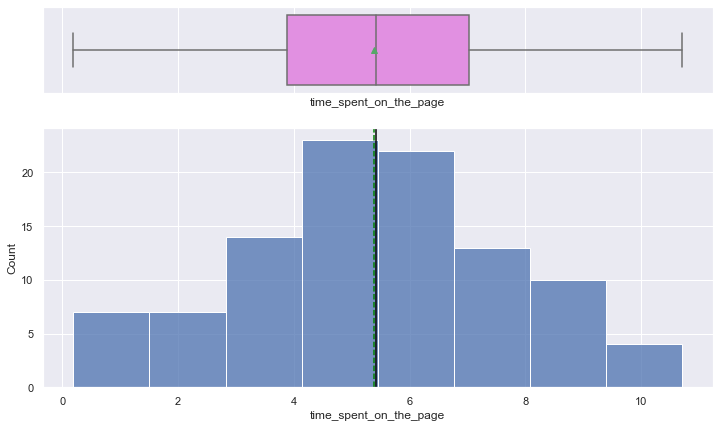

In [103]:
#Time_spent analysis
histogram_boxplot(udata, "time_spent_on_the_page")

* Normal Uniform distribution of data
* Mean time is around 5

<AxesSubplot:title={'center':'Distribution of time_spent_on_the_page'}, xlabel='time_spent_on_the_page', ylabel='Density'>

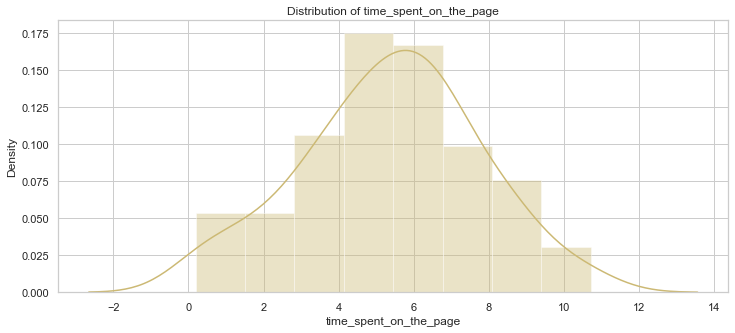

In [114]:
plt.figure(figsize = (12,5))
plt.title('Distribution of time_spent_on_the_page')
sns.distplot(udata['time_spent_on_the_page'], color = 'y')

<AxesSubplot:xlabel='language_preferred', ylabel='count'>

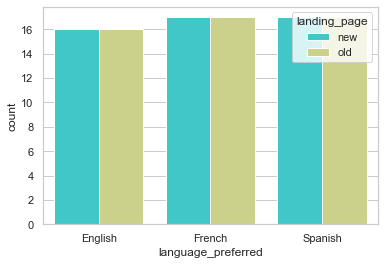

In [104]:
# Observations on language_preferred
sns.set_style('whitegrid')
sns.countplot(x='language_preferred',hue='landing_page',data=udata,palette='rainbow')

In [105]:
# function to create labeled barplots


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

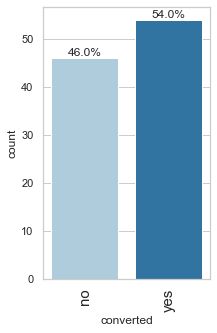

In [107]:
labeled_barplot(udata, "converted", perc=True)

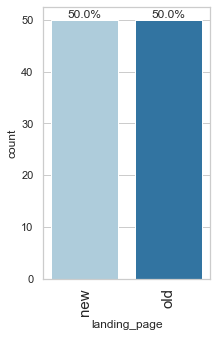

In [109]:
labeled_barplot(udata, "landing_page", perc=True)

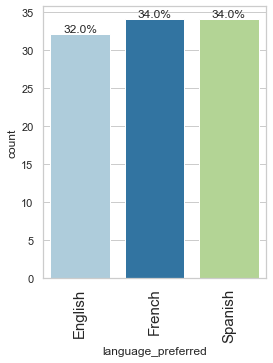

In [110]:
labeled_barplot(udata, "language_preferred", perc=True)

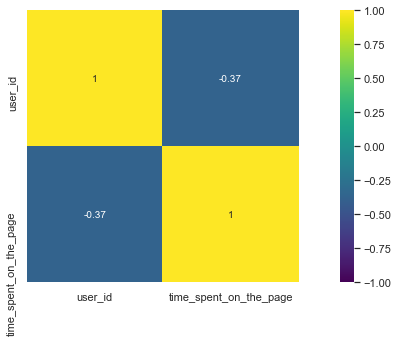

In [111]:
# Bivariate analysis
udata_corr = udata.corr()

plt.figure(figsize=(15, 5))
sns.heatmap(udata_corr,cmap='viridis',vmax=1.0, vmin=-1.0,
            annot=True,square=True)
plt.show()

* Kind of not-required here, as User_id just key for user

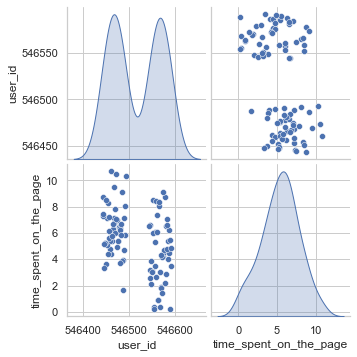

In [24]:
sns.pairplot(udata,diag_kind="kde")
plt.show()

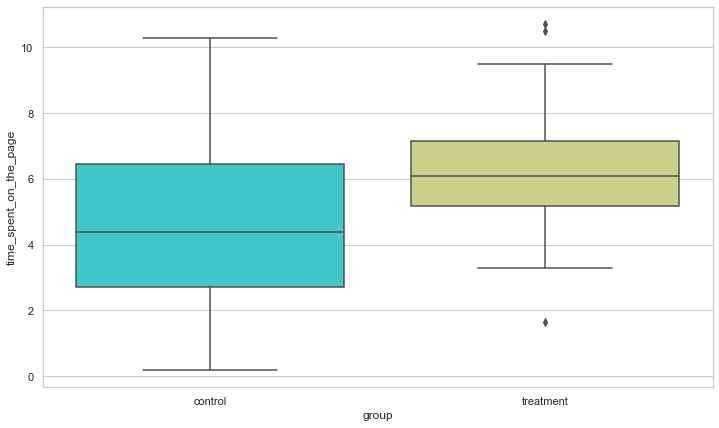

In [25]:
#group vs time spent
plt.figure(figsize=(12,7))
sns.boxplot(x='group',y='time_spent_on_the_page',data=udata,palette='rainbow')
plt.show()

* Shows some outliers for treatment group
* treatment group (people given new_page) seem to have spent more time

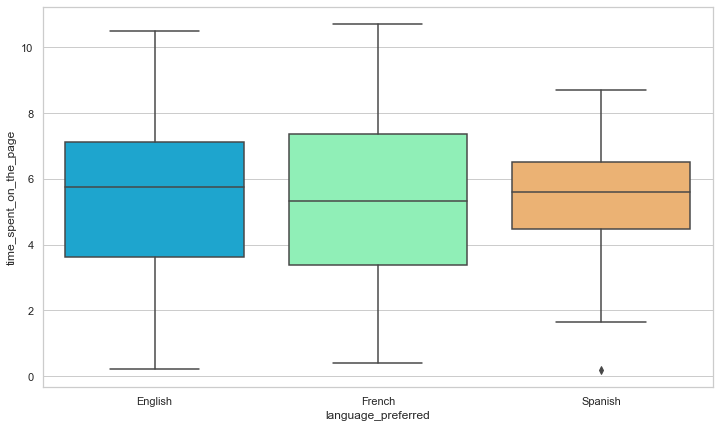

In [26]:
# language vs time spent
plt.figure(figsize=(12,7))
sns.boxplot(x='language_preferred',y='time_spent_on_the_page',data=udata,palette='rainbow')
plt.show()

* Shows average time spent by all language people are almost same.
* Spanish peole seems to have spent less time in the pages

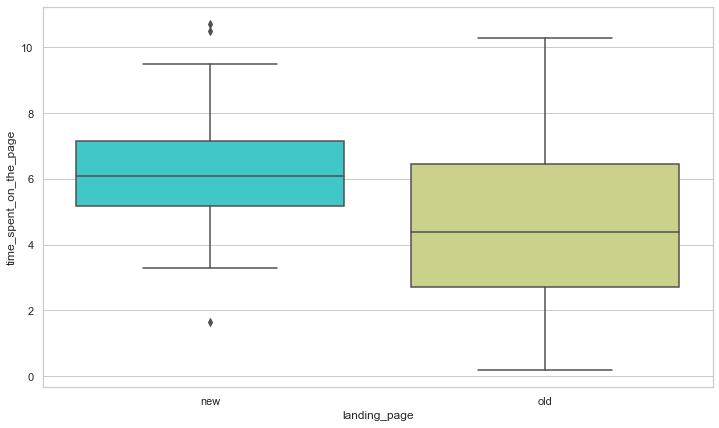

In [113]:
# landing page vs time spent
plt.figure(figsize=(12,7))
sns.boxplot(x='landing_page',y='time_spent_on_the_page',data=udata,palette='rainbow')
plt.show()

* Users spent more time in new design, which is an good sign
* There are some outliers in new page data

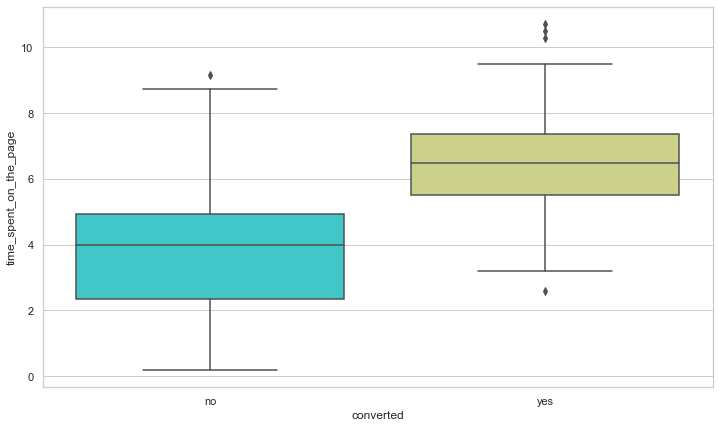

In [115]:
# landing page vs time spent
plt.figure(figsize=(12,7))
sns.boxplot(x='converted',y='time_spent_on_the_page',data=udata,palette='rainbow')
plt.show()

* Users who got converted spend more time on the pages
* Outliers present in converted users data
* Average time spent by converted users is more than the samle average that is a good sign

### EDA Insights
* As overall, new_page design has positive impact as time spent by users have increased from initial analysis
* Language does seem to influence conversion rate
* Users who spent more time seems to get converted, that is good sign for business
* Average time spent by users across language seems to be same

### Some Statistical Checking

In [31]:
#No of Converted users and the probablity of conversion
conv_user = udata.query('converted=="yes"').user_id.count()
print('No. of converted users :{}'.format(conv_user))

#probablity
convprob = conv_user/udata.shape[0]
print('Probability of converted user : {}'.format(convprob))

No. of converted users :54
Probability of converted user : 0.54


#### by above calculation, we can note that the probablity of user getting converted is around 0.54. 

In [33]:
#new page users
new_rec = udata.query('landing_page=="new"').user_id.count()
prob_new = new_rec / udata.shape[0]

print('No. of converted users :{}'.format(new_rec))
print('Probability of new page user: {}'.format(prob_new))

No. of converted users :50
Probability of new page user: 0.5


#### Above calculation indicates the number of users who get old landing page and new landing page is almost equal. 

## Do the users spend more time on the new landing page then the old landing page

In [57]:
### Average time spent diff between new and old
oldmean = np.mean(udata[udata["landing_page"]=="old"]["time_spent_on_the_page"])
newmean = np.mean(udata[udata["landing_page"]=="new"]["time_spent_on_the_page"])
print('Average time spent on new page :{}'.format(newmean))
print('Average time spent on old page :{}'.format(oldmean))
newsd = np.std(udata[udata["landing_page"]=="new"]["time_spent_on_the_page"])
oldsd = np.std(udata[udata["landing_page"]=="old"]["time_spent_on_the_page"])
print('SD of new page :{}'.format(newsd))
print('SD of old page :{}'.format(oldsd))
print("Mean time spent diff is :{}".format(newmean-oldmean))


Average time spent on new page :6.2232
Average time spent on old page :4.532400000000001
SD of new page :1.7987689568146321
SD of old page :2.556024694716387
Mean time spent diff is :1.6907999999999994


1. Continuous data - Yes, the time spent is measured on a continuous scale.
2. Normally distributed populations - Yes, we are informed that the populations are assumed to be normal.
3. Independent populations - As we are taking random samples for two different groups, the two samples are from two independent populations.
4. Unequal population standard deviations - As the sample standard deviations are different, the population standard deviations may be assumed to be different.
5. Random sampling from the population - Yes, we are informed that the collected sample a simple random sample.

So we use two-sample T-test

#### Perform statistical analysis of the problem, Time spent on Landing page
#### Null Hypothesis(H0) -Users spend same amount of time in new and old page 
#### Alternate Hypothesis(Ha) - Users spend more time in new page than old page

In [64]:
#import the required functions
from scipy.stats import ttest_ind
# Calclualte p-value
test_stat, p_value = ttest_ind(udata[udata["landing_page"]=="new"]["time_spent_on_the_page"],udata[udata["landing_page"]=="old"]["time_spent_on_the_page"],equal_var = False,alternative = 'greater')
print('The p-value is ', p_value)


The p-value is  0.0001392381225166549


#### Conclusion
As the p-value (~0.0001) is less than the level of significance, we can ***reject the null hypothesis***. Hence, we do have enough evidence to support the claim that users spend more time in new landing page compared to old page.

## Conversion rate for new page greater than conversion rate of old page

##### It is clearly two-tailed test concerning 2 population proprotion p1 & p2, the proprotion of users vsiting new landing page and converted to
##### users visting old landing page and converted

#### we would perform Two proportions Z-test
#### Null Hypothesis (H0) : p1 = p2
#### Alternate Hypothesisi (Ha): p1 != P2

In [77]:
# calculate users
# select only converted users
convusers = udata[udata["converted"]=="yes"]
convusers.landing_page.value_counts()

#Proportion of converted users visit new page
newusers = convusers.landing_page.value_counts()["new"] * 100 / udata.query('landing_page=="new"').user_id.count()

#Proportion of converted users visit old page
oldusers = convusers.landing_page.value_counts()["old"] * 100 / udata.query('landing_page=="old"').user_id.count()
newusers, oldusers

(66.0, 42.0)

#### As we can see, 66.0% new users gets converted in the dataset whereas only 42% old users gets converted. There is a significant difference in the proportion.
#### Perform statistical analysis of the problem by proportions test for it.
#### Null Hypothesis(H0) - Conversion rate for new page and old page are same. 
#### Alternate Hypothesis(Ha) - Conversion rate for new page is greater than old page are same. 

In [78]:
ulandconv = udata['landing_page'].groupby(udata['converted']).value_counts().to_frame(name = 'Converted Users')
ulandconv

Converted Users
converted landing_page                 
no        old                        29
          new                        17
yes       new                        33
          old                        21

<AxesSubplot:xlabel='converted,landing_page'>

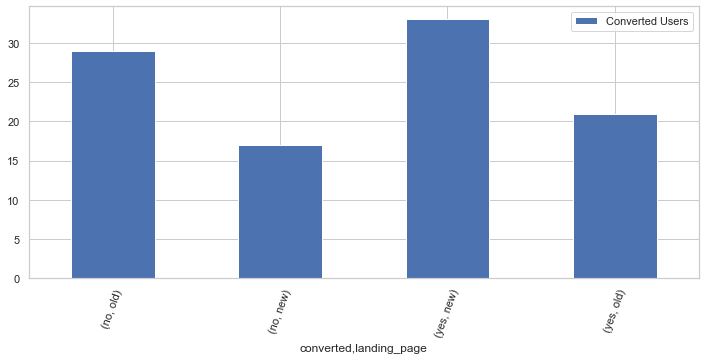

In [79]:
ulandconv.plot(kind = 'bar', figsize = (12,5), rot = 70)

***Let's test whether the Z-test assumptions are satisfied or not***
* Binomally distributed population - Yes, a user is either converted or not
* Random sampling from the population - Yes, we are informed that the collected sample is a simple random sample.
* Can the binomial distribution approximated to normal distribution - Yes. For binary data, CLT works slower than usual. The standard thing is to check whether np and n(1-p) are greater than or equal to 10. Here, n and p refer to the sample size and sample proportion respectively.
* All values are above >= 10

In [83]:
np1= udata.query('landing_page=="new"').user_id.count() * convusers.landing_page.value_counts()["new"]/udata.query('landing_page=="new"').user_id.count()
print(np1)
np2= udata.query('landing_page=="old"').user_id.count() * convusers.landing_page.value_counts()["old"]/udata.query('landing_page=="old"').user_id.count()
print(np2)
n1p1 = udata.query('landing_page=="new"').user_id.count() * ( udata.query('landing_page=="new"').user_id.count()-convusers.landing_page.value_counts()["new"])/udata.query('landing_page=="new"').user_id.count()
print(n1p1)
n1p2= udata.query('landing_page=="old"').user_id.count() * (udata.query('landing_page=="old"').user_id.count()-convusers.landing_page.value_counts()["old"])/udata.query('landing_page=="old"').user_id.count()
print(n1p2)

33.0
21.0
17.0
29.0


In [85]:
#Calculate p-value
# import the required fuction
from statsmodels.stats.proportion import proportions_ztest

# set the counts of converted users for new and old
conv_count = np.array([convusers.landing_page.value_counts()["new"], convusers.landing_page.value_counts()["old"]])

# set the sample sizes
nobs = np.array([udata.query('landing_page=="new"').user_id.count() , udata.query('landing_page=="old"').user_id.count() ])

# find the p-value
test_stat, p_value = proportions_ztest(conv_count, nobs)
print('The p-value is ' + str(p_value))

The p-value is 0.016052616408112556


#### Conclusion
As the p-value is less than the significance level 0.05, we ***reject the null hypothesis***. Thus, we do have enough statistical significance to conclude that the Conversion rate for new landing page and  old landing page are not same.

## Does Converted status depend on Pref Language

<AxesSubplot:xlabel='language_preferred', ylabel='count'>

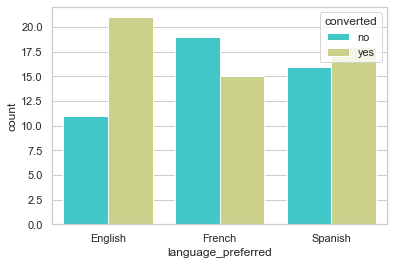

In [75]:
sns.set_style('whitegrid')
sns.countplot(x='language_preferred',hue='converted',data=udata,palette='rainbow')

Here we need to find the dependency betweeen two variables Preffered Language and Converted Status. 
We can perform Chi square test for independence by forming 2x2 contingency table for two variables (Preferred language and Converted Status) and store number of observations at each cell

In contingency table row and column variables are independent
* Categorical variables - yes
* Expected value of the number of sample observations in each level of the variable is atleast 5 - Yes
* Random Sampling from the population - Yes.

### Null Hypothesis(H0) - Converted Status depend of Preferred language
### Alternate Hypothesis(Ha) - Converted status not depend on Preferred language

In [73]:
# Prepping data to form contingency table
udata_crosstab = pd.crosstab(udata['converted'],udata['language_preferred'],margins=False)
print(udata_crosstab)


language_preferred  English  French  Spanish
converted                                   
no                       11      19       16
yes                      21      15       18


In [74]:
#Caclulate p-value 
# import the required function
from scipy.stats import chi2_contingency

# find the p-value
chi, p_value, dof, expected = chi2_contingency(udata_crosstab)
print('The p-value is', p_value)

The p-value is 0.21298887487543447


### Conclusion
With a p-value of 0.213, much greater than the significance level, we ***fail to reject the null hypothesis***. Hence we do have enough statistical evidence to conclude that Converted status depend on Preferred_language at 5% significance level

## Is mean time spent on new page same for different languages

#### Null Hypothesis(H0) - Meantime spent on new page is same for different languages
#### Alternate Hypothesis(Ha) - atleast one of the means is not the same

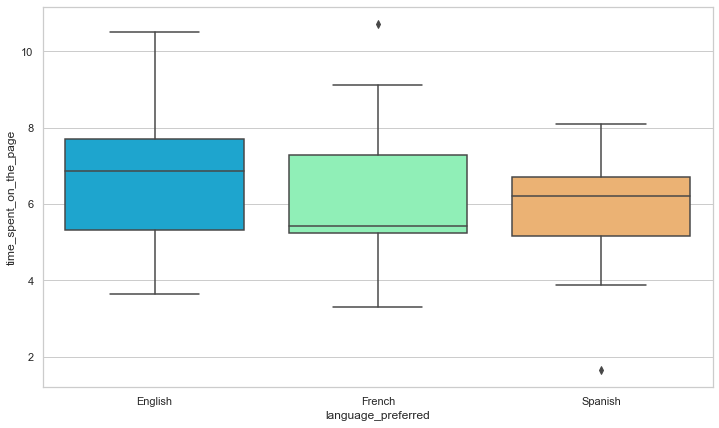

In [116]:
plt.figure(figsize=(12,7))
sns.boxplot(x='language_preferred',y='time_spent_on_the_page',data=udata.query('landing_page=="new"'),palette='rainbow')
plt.show()

#### we can see from above page the mean time spent on new page is significantly different for different languages
#### so we perform ANOVA f test.

In [46]:
# mean of time psent on new page across different languages
print((udata.query('landing_page=="new"')).groupby("language_preferred")["time_spent_on_the_page"].mean())

language_preferred
English    6.663750
French     6.196471
Spanish    5.835294
Name: time_spent_on_the_page, dtype: float64


#### Now, the normality and equality of variance assumptions to be checked
#### We will perform Shapiro-Willk's test for normality
#### Levene test for variance equality

In [47]:
#Shapiro Willk's test
#Null Hypothesis (H0) : Time spent follow normal dist.
#Alternate Hypothesis (ha): Time spent does not follow normal dist.

#import required
from scipy import stats

#find p value
w,p_value = stats.shapiro(udata.query('landing_page=="new"')["time_spent_on_the_page"])
print('P value is',p_value)

P value is 0.8040016293525696


Since P-value of the test is very large, we fail to reject the null hypothesis that the response follow normal distribution

In [49]:
#Levene's test
# Null Hypothesis (H0):All population variances are equal.
# Alternate Hypothesis (Ha): Atleast one variance is different

#import required
from scipy.stats import levene
statistic,p_value = levene(udata.query('landing_page=="new" and language_preferred=="English"')["time_spent_on_the_page"],
                          udata.query('landing_page=="new" and language_preferred=="French"')["time_spent_on_the_page"],
                          udata.query('landing_page=="new" and language_preferred=="Spanish"')["time_spent_on_the_page"])
print('P value is',p_value)

P value is 0.46711357711340173


Since p_value is large, we fail to reject null hypothesis of homogeneity of values

In [52]:
#Lets perform ANOVA test
from scipy.stats import f_oneway
test_stat,p_value = f_oneway(udata.query('landing_page=="new"').loc[udata.query('landing_page=="new"')['language_preferred']=='English','time_spent_on_the_page'],
                          udata.query('landing_page=="new"').loc[udata.query('landing_page=="new"')['language_preferred']=='Spanish','time_spent_on_the_page'],
                          udata.query('landing_page=="new"').loc[udata.query('landing_page=="new"')['language_preferred']=='French','time_spent_on_the_page'])
print('P value is',p_value)

P value is 0.43204138694325955


### Insight
As the p-value is much larger than the significance value, we ***fail to reject null-hypothesis***. Hence we do have enough statistical
evidence to conclude that the mean time spent by users on new landing page is almost same at 5% significance level.

## Summary
* New page design has positive impact
* users spending time has increased 
* Users across various language spent at an averge same time
* USers conversion rate has increase among the users who use new pages